![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)


# Subset SWOT LR L2 Unsmoothed data from AVISO's FTP Server
This notebook explains how to select and retrieve Unsmoothed (250-m) SWOT LR L2 half orbits from AVISO's FTP Server, and subset data with a geographical area.

L2 Unsmoothed data can be explored at:

* https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-validated/PGC0/Unsmoothed/catalog.html
* https://tds.aviso.altimetry.fr/thredds/catalog/dataset-l2-swot-karin-lr-ssh-validated/PIC0/Unsmoothed/catalog.html

You need to have ``xarray``, ``numpy``, ``pydap``, ``threddsclient`` and ``matplotlib``+``cartopy`` (for visualisation) packages installed in your Python environment for this notebook to work.

## Tutorial Objectives
* Download files through FTP, with selection by cycle and pass numbers
* Subset data with geographical selection

## Import + code



In [1]:
# Install Cartopy with mamba to avoid discrepancies
# ! mamba install -q -c conda-forge cartopy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
from getpass import getpass
import numpy as np
import ftplib
import xarray as xr

In [4]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [5]:
def _download_file(ftp:str, filename:str, target_directory:str):
    print(f"Download file: {filename}")
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        
def _get_last_version_filename(filenames):
    versions = {int(f[-5:-3]): f for f in filenames}
    return versions[max(versions.keys())]

def _select_filename(filenames, only_last):
    if not only_last: return filenames
    return [_get_last_version_filename(filenames)]

def ftp_download_files(ftp_path, level, variant, cycle_numbers, half_orbits, output_dir, only_last=True):
    """ Download half orbits files from AVISO's FTP Server.
    Args:
        ftp_path
            path of the FTP fileset
        level
            L2 or L3
        variant
            Basic, Expert, WindWave or Unsmoothed
        cycle_numbers
            list of cycles numbers
        half_orbits
            list of passes numbers
        output_dir
            output directory
        only_last
            if True (Default), downloads only the last version of a file if several versions exist. 
            Downloads all versions otherwise.
    Returns:
        The list of local files.
    """
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    try:
        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")
            downloaded_files = []
            
            for cycle in cycle_numbers:
                cycle_str = '{:03d}'.format(cycle)
                cycle_dir = f'cycle_{cycle_str}'
                print(ftp_path+cycle_dir)
                ftp.cwd(cycle_dir)
    
                for half_orbit in half_orbits:
                    half_orbit_str = '{:03d}'.format(half_orbit)
                    pattern = f'SWOT_{level}_LR_SSH_{variant}_{cycle_str}_{half_orbit_str}'
                    filenames = []
                    try:
                        filenames = ftp.nlst(f'{pattern}_*')
                        # No version in L3 filenames
                        if level=="L3": only_last=False
                        filenames = _select_filename(filenames, only_last)
                    except Exception as e:
                        print(f"No pass {half_orbit}")
                        
                    local_files = [_download_file(ftp, f, output_dir) for f in filenames]
                    downloaded_files += local_files
                
                ftp.cwd('../')
                
            return downloaded_files
            
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")

def _normalized_ds(ds, lon_min, lon_max):
    lon = ds.longitude.values
    lon[lon < lon_min] += 360
    lon[lon > lon_max] -= 360
    ds.longitude.values = lon
    return ds
    
def _subset_ds(file, group, variables, lon_range, lat_range):   
    swot_ds = xr.open_dataset(file, group=group)   
    swot_ds = swot_ds[variables]
    swot_ds.load()

    ds = _normalized_ds(swot_ds.copy(), -180, 180)

    mask = (
        (ds.longitude <= lon_range[1])
        & (ds.longitude >= lon_range[0])
        & (ds.latitude <= lat_range[1])
        & (ds.latitude >= lat_range[0])
    ).compute()
    
    swot_ds_area = swot_ds.where(mask, drop=True)

    for var in list(swot_ds_area.keys()):
        swot_ds_area[var].encoding = {'zlib':True, 'complevel':5}

    return swot_ds_area
    
def _to_netcdf(ds_root, ds_left, ds_right, output_file):
    """ Writes the dataset to a netcdf file """
    ds_root.to_netcdf(output_file)
    ds_right.to_netcdf(output_file, group='right', mode='a')
    ds_left.to_netcdf(output_file, group='left', mode='a')
    
def _subset_grouped_ds(file, variables, lon_range, lat_range, output_dir):    
    print(f"Subset dataset: {file}")
    ds_root = xr.open_dataset(file)
    swot_ds_right = _subset_ds(file, 'right', variables, lon_range, lat_range)
    swot_ds_left = _subset_ds(file, 'left', variables, lon_range, lat_range)

    if swot_ds_right.sizes['num_lines'] == 0 and swot_ds_left.sizes['num_lines'] == 0:
        print(f'Dataset {file} not matching geographical area.')
        return None

    filename = f"subset_{os.path.basename(file)}"
                
    print(f"Store subset: {filename}")
    filepath = os.path.join(output_dir, filename)

    _to_netcdf(ds_root, swot_ds_left, swot_ds_right, filepath)
        
    return filepath

def subset_files(filenames, variables, lon_range, lat_range, output_dir):
    """ Subset datasets with geographical area.
    Args:
        filenames
            the filenames of datasets to subset
        variables
            variables to select
        lon_range
            the longitude range
        lat_range
            the latitude range
        output_dir
            output directory
    Returns:
        The list of subsets files.
    """
    return [subset_file for subset_file in [_subset_grouped_ds(f, variables, lon_range, lat_range, output_dir) for f in filenames] if subset_file is not None]

def _interpolate_coords(ds):
    lon = ds.longitude
    lat = ds.latitude
    shape = lon.shape
    lon = np.array(lon).ravel()
    lat = np.array(lat).ravel()
    dss = xr.Dataset({
        'longitude': xr.DataArray(
                    data   = lon,
                    dims   = ['time']
                    ),
        'latitude': xr.DataArray(
                    data   = lat,
                    dims   = ['time'],
                    )
                },)
    dss_interp = dss.interpolate_na(dim="time", method="linear", fill_value="extrapolate")
    ds['longitude'] = (('num_lines', 'num_pixels'), dss_interp.longitude.values.reshape(shape))
    ds['latitude'] = (('num_lines', 'num_pixels'), dss_interp.latitude.values.reshape(shape))
    
def normalize_coordinates(ds):
    """ Normalizes the coordinates of the dataset : interpolates Nan values in lon/lat, and assign lon/lat as coordinates.
    Args:
        ds: the dataset

    Returns:
        xr.Dataset: the normalized dataset
    """
    _interpolate_coords(ds)
    return ds.assign_coords(
            {"longitude": ds.longitude, "latitude": ds.latitude}
        )

## Parameters



Define **existing** output folder to save results:



In [6]:
output_dir = "downloads"

### Authentication parameters
Enter your AVISO+ credentials



In [ ]:
username = input("Enter username:")

In [ ]:
password = getpass(f"Enter password for {username}:")

### Data parameters
Variables available in unsmoothed Swot LR L2 data are:

* time
* time_tai
* latitude
* longitude
* latitude_uncert
* longitude_uncert
* polarization_karin
* ssh_karin_2
* ssh_karin_2_qual
* ssh_karin_uncert
* sig0_karin_2
* sig0_karin_2_qual
* sig0_karin_uncert
* total_coherence
* mean_sea_surface_cnescls
* miti_power_250m
* miti_power_var_250m
* ancillary_surface_classification_flag

Define the variables you want:

In [9]:
variables = ['latitude', 'longitude', 'time', 'sig0_karin_2', 'ancillary_surface_classification_flag', 'ssh_karin_2', 'ssh_karin_2_qual']

Define a geographical area

In [10]:
# California
lat_range = 35, 42
lon_range = -127, -121
localbox = [lon_range[0], lon_range[1], lat_range[0], lat_range[1]]
localbox

[-127, -121, 35, 42]

Define the FTP filepath

In [11]:
ftp_path = '/swot_products/l2_karin/l2_lr_ssh/PIC0/Unsmoothed/'

# For selecting files with a regex pattern
variant = "Unsmoothed"

level = "L2"

Define data parameters

<div class="alert alert-info"><b>Note</b><p>Passes matching a geographical area and period can be found using this [tutorial](https://swot-community.github.io/SWOT-galleries/SWOT-Oceanography/ex_search_swot.html)</p></div>

In [12]:
# Define cycles and half_orbits numbers to download
cycle_numbers = [20]
pass_numbers = [11, 24, 39, 52, 67, 274, 289, 302, 317]

## Download files through FTP

In [13]:
downloaded_files = ftp_download_files(ftp_path, level, variant, cycle_numbers, pass_numbers, output_dir, only_last=True)

Connection Established 220 192.168.10.119 FTP server ready
/swot_products/l2_karin/l2_lr_ssh/PIC0/Unsmoothed/cycle_020
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_011_20240821T002444_20240821T011532_PIC0_01.nc
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_024_20240821T113333_20240821T122500_PIC0_01.nc
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_039_20240822T002515_20240822T011604_PIC0_01.nc
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_052_20240822T113404_20240822T122531_PIC0_01.nc
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_067_20240823T002546_20240823T011634_PIC0_01.nc
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_274_20240830T095520_20240830T104647_PIC0_01.nc
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_289_20240830T224702_20240830T233829_PIC0_01.nc
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_302_20240831T095551_20240831T104718_PIC0_01.nc
Download file: SWOT_L2_LR_SSH_Unsmoothed_020_317_20240831T224734_20240831T233901_PIC0_01.nc


In [14]:
downloaded_files

['downloads/SWOT_L2_LR_SSH_Unsmoothed_020_011_20240821T002444_20240821T011532_PIC0_01.nc',
 'downloads/SWOT_L2_LR_SSH_Unsmoothed_020_024_20240821T113333_20240821T122500_PIC0_01.nc',
 'downloads/SWOT_L2_LR_SSH_Unsmoothed_020_039_20240822T002515_20240822T011604_PIC0_01.nc',
 'downloads/SWOT_L2_LR_SSH_Unsmoothed_020_052_20240822T113404_20240822T122531_PIC0_01.nc',
 'downloads/SWOT_L2_LR_SSH_Unsmoothed_020_067_20240823T002546_20240823T011634_PIC0_01.nc',
 'downloads/SWOT_L2_LR_SSH_Unsmoothed_020_274_20240830T095520_20240830T104647_PIC0_01.nc',
 'downloads/SWOT_L2_LR_SSH_Unsmoothed_020_289_20240830T224702_20240830T233829_PIC0_01.nc',
 'downloads/SWOT_L2_LR_SSH_Unsmoothed_020_302_20240831T095551_20240831T104718_PIC0_01.nc',
 'downloads/SWOT_L2_LR_SSH_Unsmoothed_020_317_20240831T224734_20240831T233901_PIC0_01.nc']

## Subset data in the required geographical area

In [15]:
subset_filenames = subset_files(downloaded_files, variables, lon_range, lat_range, output_dir)

Subset dataset: downloads/SWOT_L2_LR_SSH_Unsmoothed_020_011_20240821T002444_20240821T011532_PIC0_01.nc
Store subset: subset_SWOT_L2_LR_SSH_Unsmoothed_020_011_20240821T002444_20240821T011532_PIC0_01.nc
Subset dataset: downloads/SWOT_L2_LR_SSH_Unsmoothed_020_024_20240821T113333_20240821T122500_PIC0_01.nc
Store subset: subset_SWOT_L2_LR_SSH_Unsmoothed_020_024_20240821T113333_20240821T122500_PIC0_01.nc
Subset dataset: downloads/SWOT_L2_LR_SSH_Unsmoothed_020_039_20240822T002515_20240822T011604_PIC0_01.nc
Store subset: subset_SWOT_L2_LR_SSH_Unsmoothed_020_039_20240822T002515_20240822T011604_PIC0_01.nc
Subset dataset: downloads/SWOT_L2_LR_SSH_Unsmoothed_020_052_20240822T113404_20240822T122531_PIC0_01.nc
Store subset: subset_SWOT_L2_LR_SSH_Unsmoothed_020_052_20240822T113404_20240822T122531_PIC0_01.nc
Subset dataset: downloads/SWOT_L2_LR_SSH_Unsmoothed_020_067_20240823T002546_20240823T011634_PIC0_01.nc
Store subset: subset_SWOT_L2_LR_SSH_Unsmoothed_020_067_20240823T002546_20240823T011634_PIC0_0

In [16]:
subset_filenames

['downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_011_20240821T002444_20240821T011532_PIC0_01.nc',
 'downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_024_20240821T113333_20240821T122500_PIC0_01.nc',
 'downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_039_20240822T002515_20240822T011604_PIC0_01.nc',
 'downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_052_20240822T113404_20240822T122531_PIC0_01.nc',
 'downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_067_20240823T002546_20240823T011634_PIC0_01.nc',
 'downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_274_20240830T095520_20240830T104647_PIC0_01.nc',
 'downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_289_20240830T224702_20240830T233829_PIC0_01.nc',
 'downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_302_20240831T095551_20240831T104718_PIC0_01.nc',
 'downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_317_20240831T224734_20240831T233901_PIC0_01.nc']

## Visualise data on a pass



Open a pass dataset



In [25]:
subset_file = "downloads/subset_SWOT_L2_LR_SSH_Unsmoothed_020_317_20240831T224734_20240831T233901_PIC0_01.nc"

In [26]:
ds_left = xr.open_dataset(subset_file, group="left")

In [27]:
ds_right = xr.open_dataset(subset_file, group="right")

Interpolate coordinates to fill Nan values in latitude and longitude, and assign them as coordinates.



In [28]:
ds_left = normalize_coordinates(ds_left)
ds_right = normalize_coordinates(ds_right)

### Plot Sigma 0



Mask invalid data



In [29]:
for dss in ds_left, ds_right:
    dss["sig0_karin_2"] = dss.sig0_karin_2.where(dss.ancillary_surface_classification_flag==0)
    dss["sig0_karin_2"] = dss.sig0_karin_2.where(dss.sig0_karin_2 < 1e6)
    #dss["sig0_karin_2_log"] = 10*np.log10(dss["sig0_karin_2"])

Plot data



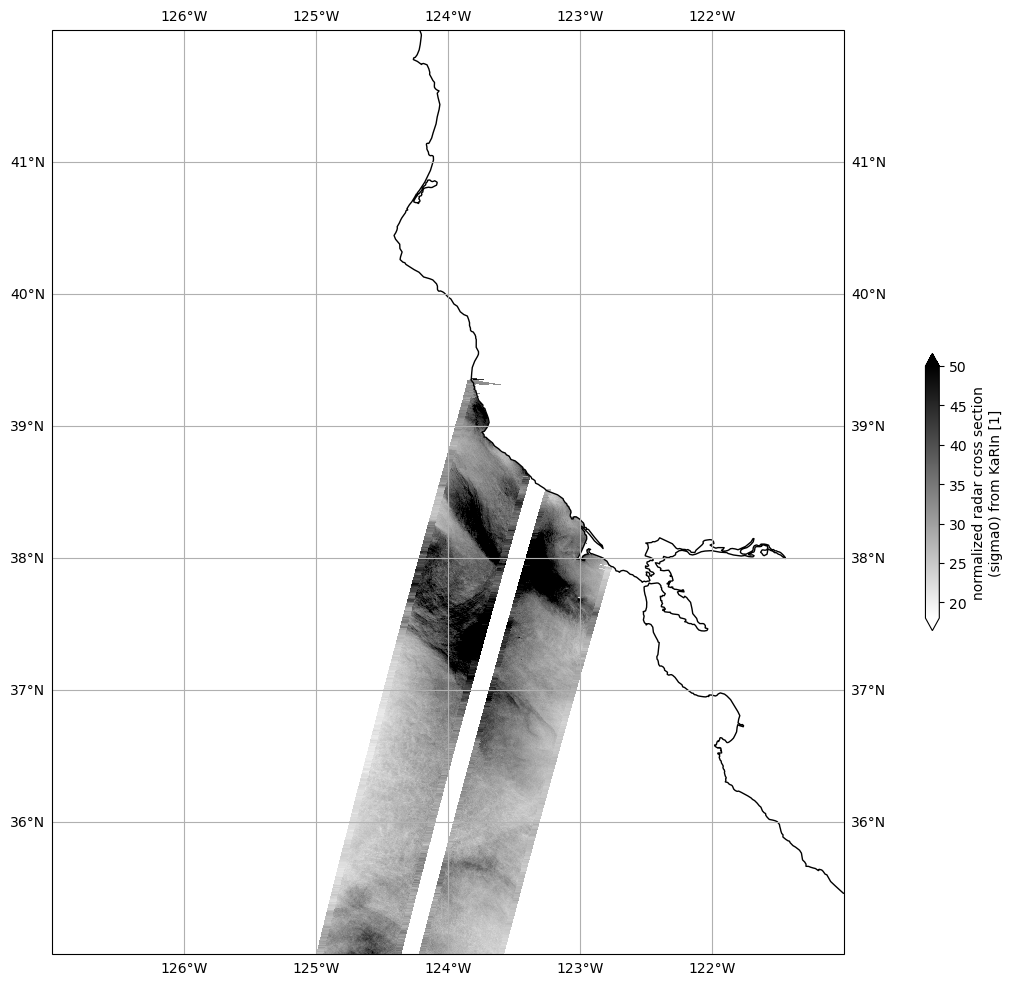

In [30]:
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="gray_r",
    vmin=18,
    vmax=50,
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_left.sig0_karin_2.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)
ds_right.sig0_karin_2.plot.pcolormesh(ax=ax, add_colorbar=False, **plot_kwargs)

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent(localbox, crs=ccrs.PlateCarree())

### Plot SSHA



Mask invalid data



In [31]:
for dss in ds_left, ds_right:
    dss["ssh_karin_2"] = dss.ssh_karin_2.where(dss.ancillary_surface_classification_flag==0)
    dss["ssh_karin_2"] = dss.ssh_karin_2.where(dss.ssh_karin_2_qual==0)

Plot data



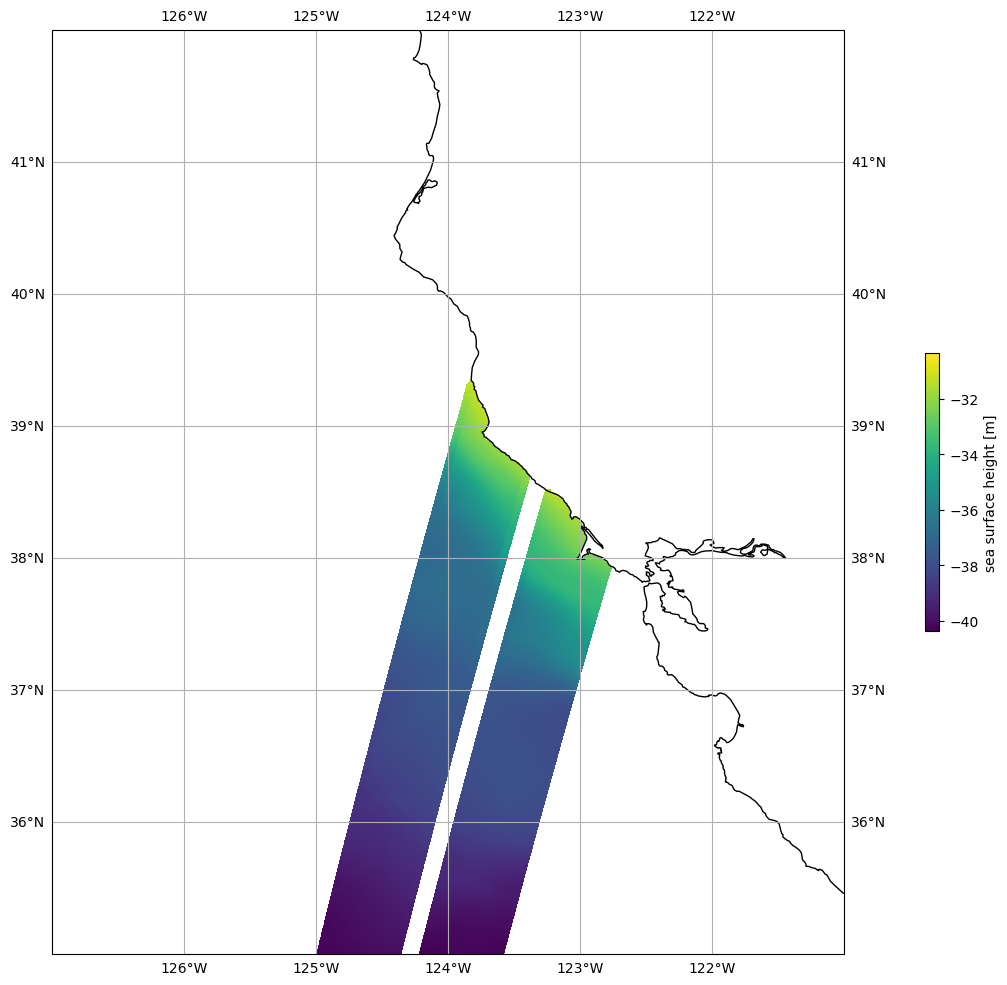

In [32]:
plot_kwargs = dict(
    x="longitude",
    y="latitude"
)

fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ds_left.ssh_karin_2.plot.pcolormesh(ax=ax, cbar_kwargs={"shrink": 0.3}, **plot_kwargs)
ds_right.ssh_karin_2.plot.pcolormesh(ax=ax, add_colorbar=False, **plot_kwargs)

ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_extent(localbox, crs=ccrs.PlateCarree())